In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline
plt.style.use('seaborn-colorblind')

df = pd.read_excel('Hire Heroes Audience Overview.xlsx')
df.tail()

,Day Index,Sessions
1371,2016-01-02,3172
1372,2016-01-03,3261
1373,2016-01-04,3925
1374,2016-01-05,3991
1375,2016-01-06,4141


In [2]:
# Check Day Index is of datetime type
df.dtypes

Day Index    datetime64[ns]
Sessions              int64
dtype: object

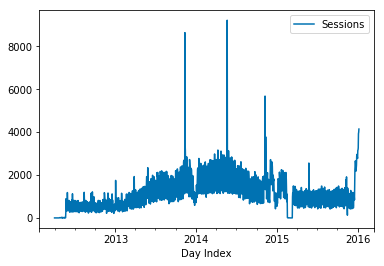

In [3]:
# Take a look at a plot of the data
df.set_index('Day Index').plot()

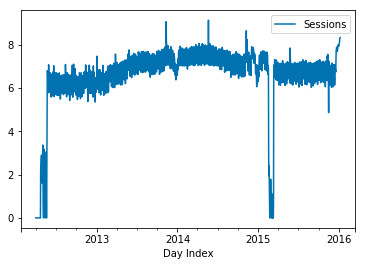

In [4]:
# Convert Sessions to a log value to understand the data's behavior linearly. 
df['Sessions'] = np.log(df['Sessions'])
df.set_index('Day Index').plot()

In [5]:
# For the Prophet API, rename Day Index and Sessions to ds and y
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2012-04-01,0.0
1,2012-04-02,0.0
2,2012-04-03,0.0
3,2012-04-04,0.0
4,2012-04-05,0.0


In [6]:
# Fit the model to the data
model1 = Prophet()
model1.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
# Define how far in the future for Prophet to predict
future1 = model1.make_future_dataframe(periods=365)

# Apply predict
forecast1 = model1.predict(future1)

In [8]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1736,2017-01-01,7.254758,5.244253,9.306086
1737,2017-01-02,7.849593,5.892222,9.994509
1738,2017-01-03,7.852711,5.811779,9.966881
1739,2017-01-04,7.837309,5.962528,9.845347
1740,2017-01-05,7.780694,5.680546,9.903556


#### We get a dataframe, forecast1, with the predicted value (yhat) and range (yhat_lower and yhat_upper)

In [9]:
# Convert back to numeric values 
np.exp(forecast1[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
1736,1414.819869,189.474161,11004.790473
1737,2564.690435,362.209202,21905.848263
1738,2572.700210,334.213048,21308.915680
1739,2533.379067,388.591106,18870.344561
1740,2393.935539,293.109365,20001.369840


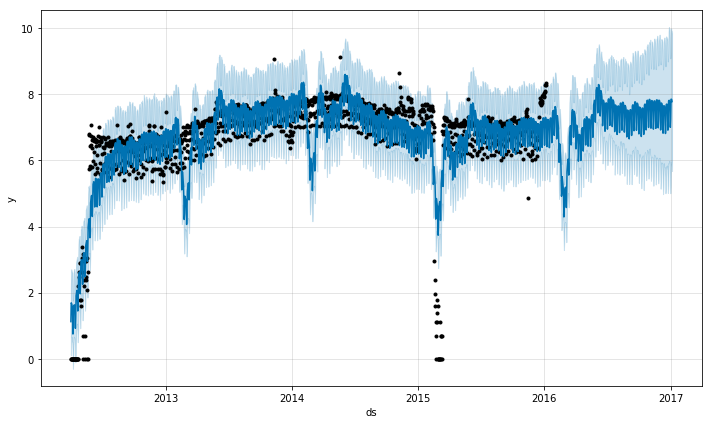

In [10]:
# Visualize the forecasts
model1.plot(forecast1);

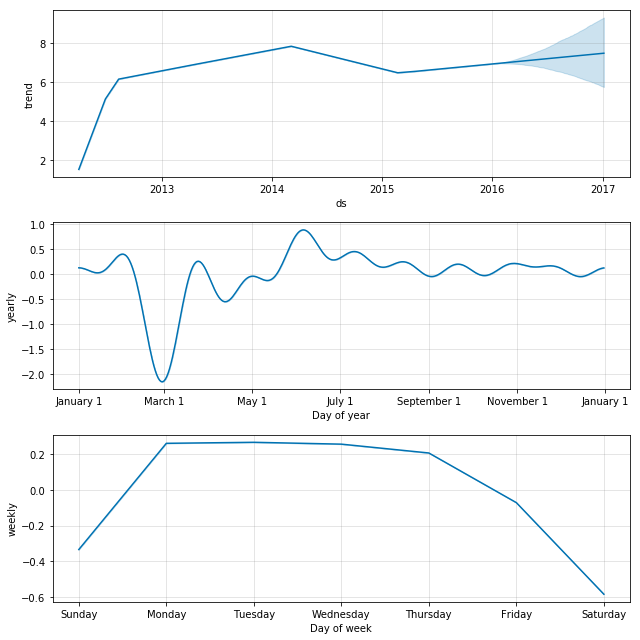

In [11]:
# Prophet can also plot different components 
model1.plot_components(forecast1);

#### Weekdays trend higher for traffic and we see a big drop off after the holiday season with a pickup leading up to July.  Looking at the trends and seeing the increase and peak heading into July, I want to define Patriotic holidays as known events and apply the model to these to hopefully improve our predictions.  

In [12]:
# Define holiday dataframe made up of Memorial, Flag, Independence, Patriot and Veteran's Days
# Define range of days to account for days leading up to and after the holidays
calendar = pd.DataFrame({
    'holiday': 'patriotic',
    'ds': pd.to_datetime(['2012-05-28', '2012-06-14', '2012-07-04', '2012-09-11', '2012-11-11',
                          '2013-05-27', '2013-06-14', '2013-07-04', '2013-09-11', '2013-11-11',
                          '2014-05-26', '2014-06-14', '2014-07-04', '2014-09-11', '2014-11-11',
                          '2015-05-25', '2015-06-14', '2015-07-04', '2015-09-11', '2015-11-11',
                          '2016-05-30', '2016-06-14', '2016-07-04', '2016-09-11', '2016-11-11']),
    'lower_window': -5,
    'upper_window': 5,
})

calendar.head()

,ds,holiday,lower_window,upper_window
0,2012-05-28,patriotic,-5,5
1,2012-06-14,patriotic,-5,5
2,2012-07-04,patriotic,-5,5
3,2012-09-11,patriotic,-5,5
4,2012-11-11,patriotic,-5,5


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


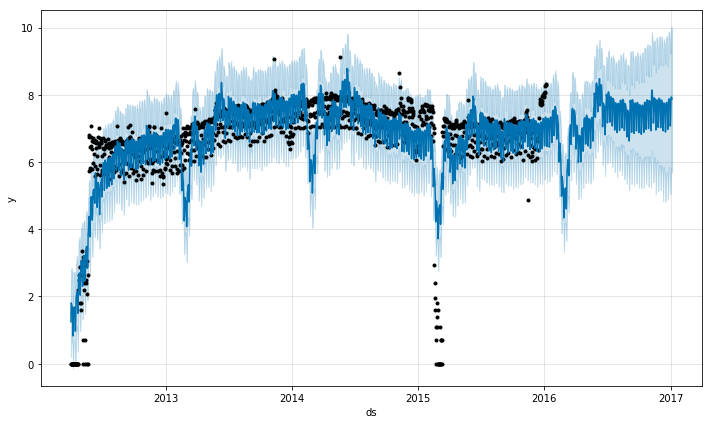

In [13]:
# Pass the calendar df to the model and call fit, predict, and plot
model2 = Prophet(holidays=calendar).fit(df)
future2 = model2.make_future_dataframe(periods=365)
forecast2 = model2.predict(future2)
model2.plot(forecast2);

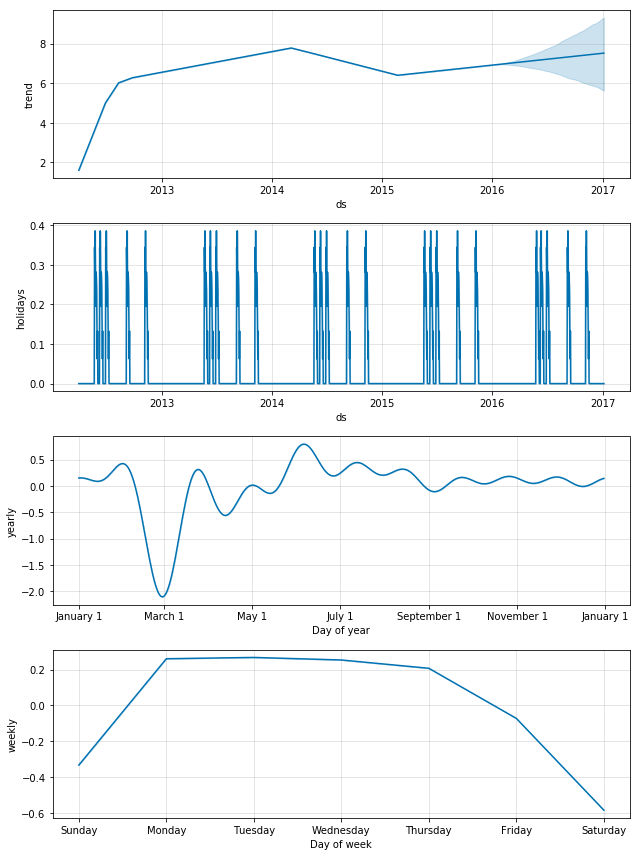

In [14]:
# Plot the components 
model2.plot_components(forecast2);

#### The holiday effects will show up in the components plot, where we see that there's spikes on the days around the patriotic holidays. 

### Uncertainty in Seasonality
#### Prophet documentation says by default Prophet will only return uncertainty in the trend and observation noise.  To get uncertainty in seasonality, Bayesian sampling is needed.  Prophet uses the parameter mcmc_samples.

In [15]:
model3 = Prophet(holidays=calendar, mcmc_samples=300).fit(df)
future3 = model3.make_future_dataframe(periods=365)
forecast3 = model3.predict(future3)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
# Output for the forecast of website traffic for the year
forecast3["Sessions"] = np.exp(forecast3.yhat).round()
forecast3["Sessions_Lower_Range"] = np.exp(forecast3.yhat_lower).round()
forecast3["Sessions_Upper_Range"] = np.exp(forecast3.yhat_upper).round()
forecast3[(forecast3.ds > "1-1-2016") & 
          (forecast3.ds < "1-1-2017")][["ds", "yhat", "Sessions_Lower_Range", "Sessions", "Sessions_Upper_Range"]]

,ds,yhat,Sessions_Lower_Range,Sessions,Sessions_Upper_Range
1371,2016-01-02,6.541346,241.0,693.0,1872.0
1372,2016-01-03,6.803843,342.0,901.0,2655.0
1373,2016-01-04,7.399517,597.0,1635.0,4819.0
1374,2016-01-05,7.405831,554.0,1646.0,4497.0
1375,2016-01-06,7.390844,592.0,1621.0,4109.0
1376,2016-01-07,7.341829,574.0,1544.0,4471.0
1377,2016-01-08,7.056262,417.0,1160.0,3374.0
1378,2016-01-09,6.539357,247.0,692.0,1852.0
1379,2016-01-10,6.792307,336.0,891.0,2473.0
1380,2016-01-11,7.381078,565.0,1605.0,4303.0


#### The output for the predictions and ranges for the year for Hire Heroes website traffic.  